# Embedding graphs in Minkowski spacetime


> The views of space and time which I wish to lay before you have sprung from the soil of experimental physics, and therein lies their strength. They are radical. Henceforth space by itself, and time by itself, are doomed to fade away into mere shadows, and only a kind of union of the two will preserve an independent reality. — Hermann Minkowski, 1908

![title](../images/lightcone.svg.png)

#### **Implementation of Lorentzian graph embeddings:**

**[1]** Clough JR, Evans TS (2017) Embedding graphs in Lorentzian spacetime. PLoS ONE 12(11):e0187301. https://doi.org/10.1371/journal.pone.0187301<br>

The authors also released their own open-source Python library that can be found here: https://github.com/JamesClough/dagology

**Two Main Steps:**<br>
- Given some input DAG, we compute a pairwise dissimilarity matrix by estimating space-like and time-like separations. <br>
- Apply generalized Lorentzian MDS with this separation matrix


Given only pairwise separations $M_{ij}$, can we recover coordinates in Lorentzian spacetime which respect these separations?

**DAG Embedding Algorithm:**<br>
1. For every pair $i$ and $j$ connected by a directed path, find length of the longest directed path between them, $L_{i j}$
2. For every other pair, find the naive spacelike distance $N_{i j}$ .
3. Create separation matrix, M, such that $M_{i j}$ = $-L_{i j}^{2}$ if there is a path from $i$ to $j$ and
$N_{i j}^{2}$ otherwise.
4. Use Lorentzian MDS with $\mathrm{M}$ as the input matrix of squared separations.

## Ex.) Estimating Minkowski separation for Causal set graph

In [1]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
# plotting style
%matplotlib inline
plt.style.use('seaborn')
# display multiple outputs within a cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all";
# ignore warnings
import warnings
warnings.filterwarnings('ignore');

Minkowski distance/separation between pair i,j: $$M_{i j}=M\left(\mathbf{x}_{i}, \mathbf{x}_{j}\right)=-c^{2}\left(x_{i}^{0}-x_{j}^{0}\right)^{2}+\sum_{k=1}^{d}\left(x_{i}^{k}-x_{j}^{k}\right)^{2}$$
If $M_{ij} < 0:$ time-like separated (can be causally connected)<br>
If $M_{ij} > 0:$ space-like separated (NOT causally connected)<br>
If $M_{ij} = 0:$ light-like separated (on the light-cone boundary)

In [2]:
def minkowski_dist(x, y, c=1):
    """Minkowski separation between x and y, c = speed of light parameter"""
    d0 = -c**2 * (x[0] - y[0])**2
    d1 = np.sum((x[1:] - y[1:])**2)
    return d0 + d1

def minkowski_interval(N, D):
    """ Sample N points from minkowski interval [a,b]^D, where each sample point is in causal
    future of endpoint a and causal past of endpoint b (page 4 from https://arxiv.org/abs/1408.1274)
    
    Parameters: N: observations, D: minkowski dimension """
    R = np.random.random((N, D))
    a = np.concatenate(([0], np.zeros(D-1)+0.5))
    b = np.concatenate(([1], np.zeros(D-1)+0.5))
    R[0] = a
    R[1] = b
    for i in range(2, N):
        while (minkowski_dist(a, R[i, :]) > 0) or ((minkowski_dist(R[i, :], b) > 0)):
            R[i, :] = np.random.random(D)
    return R

def uniform_box_graph(n, d=2):
    """Sample N points from minkowski interval [0,1]^D and connect timelike coordinates
    with directed edge from past to future
    
    Parameters: n observations, d dimension
    Return: Directed acyclic graph G
    """
    X = np.random.random((n, d))
    G = nx.DiGraph()
    for i in range(n):
        G.add_node(i, position=X[i])
        for j in range(i, n):
            if minkowski_dist(X[i], X[j]) < 0:
                if X[i][0] < X[j][0]:
                    G.add_edge(i, j)
                else:
                    G.add_edge(j, i)
    return G

def causal_set_graph(n, d=2):
    """Sample N points from minkowski interval [a,b]^D and connect timelike coordinates
    with directed edge from past to future
    
    Parameters: n observations, d dimension
    Return: Directed acyclic graph G
    """
    X = minkowski_interval(n, d)
    G = nx.DiGraph()
    n = X.shape[0]
    for i in range(n):
        G.add_node(i, position=X[i])
        for j in range(i, n):
            if minkowski_dist(X[i], X[j]) < 0:
                if X[i][0] < X[j][0]:
                    G.add_edge(i, j)
                else:
                    G.add_edge(j, i)
    return G

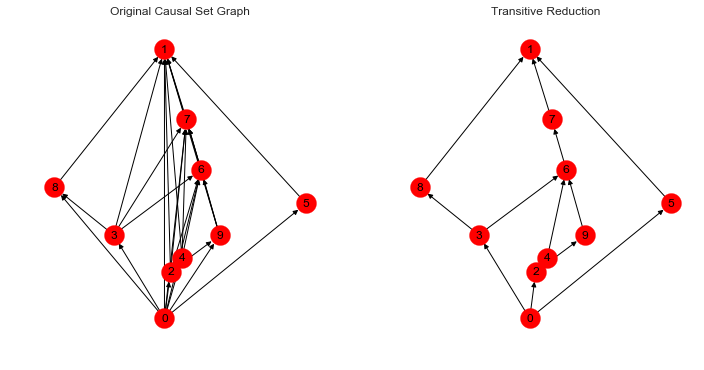

In [3]:
# plot causal set graph & transitive reduction
N = 10
G = causal_set_graph(N, 2)
options = {'node_size': 400,
           'width': 1,
           'with_labels': True}
draw_pos = {i:G.node[i]['position'][::-1] for i in range(N)}
trans_G = nx.transitive_reduction(G)
plt.figure(figsize=(12, 6))
plt.subplot(121)
nx.draw(G, pos=draw_pos, **options)
plt.title('Original Causal Set Graph')
plt.subplot(122)
plt.title('Transitive Reduction')
nx.draw(trans_G, pos=draw_pos, **options);

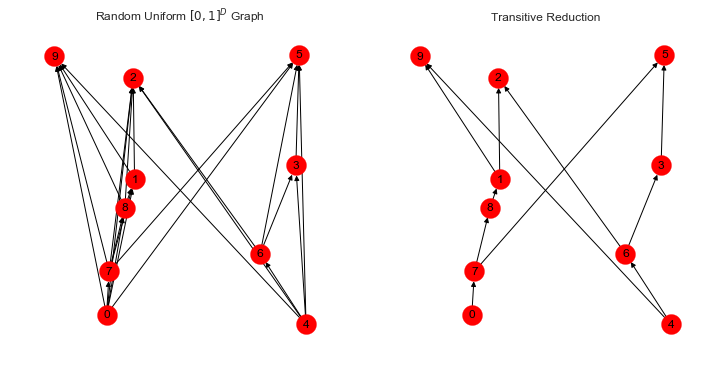

In [5]:
# plot uniform rectangle graph and transitive reduction
N = 10
G = uniform_box_graph(N, 2)
draw_pos = {i:G.node[i]['position'][::-1] for i in range(N)}
trans_G = nx.transitive_reduction(G)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.title(r'Random Uniform $[0,1]^D$ Graph')
nx.draw(G, pos=draw_pos, **options)
plt.subplot(122)
plt.title('Transitive Reduction')
nx.draw(trans_G, pos=draw_pos, **options);

In [12]:
# longest path distance between s, t
def longest_path(G, s, t):
    """Find longest directed path from node s to node t
    
    Parameters: G - directed acyclic graph, s - source node, t - target node
    Return: int - num. edges in longest path
    """
    if s!= t and nx.has_path(G, source=s, target=t):
        path_lengths = [len(x) for x in list(nx.all_simple_paths(G, source=s, target=t))]
        return max(path_lengths)
    else:
        return 0

# get longest path lengths for all time-separated nodes
def longest_paths(G):
    """Find longest directed paths between all time-separated nodes
    
    Parameters: G - directed acyclic graph
    Return: N x N matrix with pairwise longest paths - L_ij^2
    """
    n = len(list(G.nodes()))
    node_list = list(G.nodes())
    M = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            M[i][j] = -longest_path(G, node_list[i], node_list[j])**2
    # let longest path separation matrix be symmetric
    return M + np.transpose(M)

In [13]:
# get naive spacelike distances if no path i --> j
def naive_spatial_distances(L, G):
    """Find pairwise space-like separations between disconnected nodes
    
    Parameters: L - NxN time-like separation matrix, G - directed acyclic graph
    Return: M - NxN minkowski separation matrix
    """
    M = L.copy()
    n = L.shape[0]
    node_list = list(G.nodes())
    max_dist = np.max(np.abs(L))
    for i in range(n):
        for j in range(i, n):
            if  L[i,j] == 0 and (i != j):
                past_i = nx.ancestors(G, node_list[i])
                past_j = nx.ancestors(G, node_list[j])
                common_past = list(past_i.intersection(past_j))
                future_i = nx.descendants(G, node_list[i])
                future_j = nx.descendants(G, node_list[j])
                common_future = list(future_i.intersection(future_j))
                naive_dists = []
                if (len(common_past) > 0) and (len(common_future) > 0):
                    for k in common_past:
                        for l in common_future:
                            L_kl = longest_path(G, k, l)
                            if L_kl != 0:
                                naive_dists.append(L_kl)
                            else:
                                naive_dists.append(max_dist)
                    S_ij = np.min(naive_dists)**2
                    M[i,j] = S_ij
                    M[j,i] = S_ij
                else:
                    M[i,j] = max_dist
                    M[j,i] = max_dist
    return M

In [14]:
def LorentzMDS(M, d):
    """Performs Lorentzian Multidimensional Scaling
    Parameters
    ----------
    M : Minkowski separation matrix (n x n)
    d: Dimension of the output configuration
    
    Returns
    -------
    X : Matrix with columns as the output embedding vectors (n x d)
    """
    # get shape of distance matrix                                                                         
    n = M.shape[0]
    
    # centering matrix
    C = np.identity(n) -(1/n)*np.ones((n,n))
    
    # compute gram matrix                                                                                    
    B = -(1/2)*C.dot(M).dot(C)
    
    # solve for eigenvectors and eigenvalues and sort descending                                                   
    w, v = np.linalg.eigh(B)                                                  
    idx = np.argsort(w)[::-1]
    eigvals = w[idx]
    eigvecs = v[:,idx]
    
    # select d-1 largest positive eigenvalues/eigenvectors and most negative eigenvalue/eigenvector
    S  = np.diag(np.concatenate((np.sqrt(-1*eigvals[-1:]), np.sqrt(eigvals[:d-1]))))
    U  = np.hstack((eigvecs[:,-1:], eigvecs[:,:d-1]))
    X  = np.dot(S, np.transpose(U))
    X = np.transpose(X)

    return X

In [61]:
from sklearn.metrics import auc

def add_edges(X, c=1):
    """Predict edges from embedding coordinates in Minkowski spacetime, add directed edge
    if nodes have corresponding spacetime coordinates that are time-separated
    
    Parameters: X - N x d array with Minkowski spacetime coordinates
    Return: edges - list of directed edges (i, j)
    """
    n = X.shape[0]
    edges = []
    for i in range(n):
        for j in range(i, n):
            if minkowski_dist(X[i], X[j], c) < 0:
                if X[i][0] < X[j][0]:
                    edges.append((i, j))
                else:
                    edges.append((j, i))
    return edges

# define evaluation metrics to test edge predictions in graph recreation
def sensitivity(G, pred_E):
    # True positive rate
    E = list(G.edges())
    node_list = list(G.nodes())
    return len([x for x in E if x in pred_E]) / len(E)

def specificity(G, pred_E):
    # False positive rate = 1 - specificity
    A = nx.adjacency_matrix(G).toarray()
    non_edges = [tuple(x) for x in np.argwhere(A == 0)]
    n = A.shape[0]
    node_list = list(G.nodes())
    pred_A = np.zeros((n, n))
    for edge in pred_E:
        i = node_list.index(edge[0])
        j = node_list.index(edge[1])
        pred_A[i][j] = 1
    pred_non_edges = [tuple(x) for x in np.argwhere(pred_A == 0)]
    return len([x for x in non_edges if x in pred_non_edges]) / len(non_edges)

def roc_auc_score(G, X_embed):
    tpr = []
    fpr = []
    node_list = list(G.nodes())
    for c in [0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000]:
        pred_E = add_edges(X_embed, c)
        pred_E = [(node_list[e[0]], node_list[e[1]]) for e in pred_E]
        tpr.append(sensitivity(G, pred_E))
        fpr.append(1 - specificity(G, pred_E))
    tpr.append(1)
    fpr.append(1)
    return auc(fpr, tpr)

def plot_roc_curve(G, X_embed):
    tpr = []
    fpr = []
    node_list = list(G.nodes())
    for c in [0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000]:
        pred_E = add_edges(X_embed, c)
        pred_E = [(node_list[e[0]], node_list[e[1]]) for e in pred_E]
        tpr.append(sensitivity(G, pred_E))
        fpr.append(1 - specificity(G, pred_E))
    tpr.append(1)
    fpr.append(1)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=3, label='ROC curve (area = %0.2f)' % auc(fpr, tpr))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.scatter(fpr, tpr, color='black')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right", edgecolor='black', fontsize=12)
    plt.show();

In [62]:
class MinkowskiEmbedding():
    """
    Given a directed acyclic graph, compute Minkowski separations and apply
    Lorentzian Multidimensional Scaling to find spacetime embedding coordinates. 
    
    API design is modeled on the standard scikit-learn Classifier API
    """
    
    def __init__(self, n_components=2):
        self.n_components = n_components
        
    # longest path distance between s, t
    def longest_path(self, G, s, t):
        """Find longest directed path from node s to node t

        Parameters: G - directed acyclic graph, s - source node, t - target node
        Return: int - num. edges in longest path
        """
        if s!= t and nx.has_path(G, source=s, target=t):
            path_lengths = [len(x) for x in list(nx.all_simple_paths(G, source=s, target=t))]
            return max(path_lengths)
        else:
            return 0
        
    # get longest path lengths for all time-separated nodes
    def longest_paths(self, G):
        """Find longest directed paths between all time-separated nodes

        Parameters: G - directed acyclic graph
        Return: N x N matrix with pairwise longest paths - L_ij^2
        """
        n = len(list(G.nodes()))
        node_list = list(G.nodes())
        M = np.zeros((n, n))
        for i in range(n):
            for j in range(n):
                M[i][j] = -self.longest_path(G, node_list[i], node_list[j])**2
        # let longest path separation matrix be symmetric
        self.time_separations = M + np.transpose(M)
    
    # get naive spacelike distances if no path i --> j
    def naive_spatial_distances(self, G, max_dist=None):
        """Find pairwise space-like separations between disconnected nodes

        Parameters: L - NxN time-like separation matrix, G - directed acyclic graph
        Return: M - NxN minkowski separation matrix
        """
        M = self.time_separations
        n = M.shape[0]
        node_list = list(G.nodes())
        if max_dist == None:
            max_dist = np.max(np.abs(M))
        for i in range(n):
            for j in range(i, n):
                if  M[i,j] == 0 and (i != j):
                    past_i = nx.ancestors(G, node_list[i])
                    past_j = nx.ancestors(G, node_list[j])
                    common_past = list(past_i.intersection(past_j))
                    future_i = nx.descendants(G, node_list[i])
                    future_j = nx.descendants(G, node_list[j])
                    common_future = list(future_i.intersection(future_j))
                    naive_dists = []
                    if (len(common_past) > 0) and (len(common_future) > 0):
                        for k in common_past:
                            for l in common_future:
                                L_kl = self.longest_path(G, k, l)
                                if L_kl != 0:
                                    naive_dists.append(L_kl)
                                else:
                                    naive_dists.append(max_dist)
                        S_ij = np.min(naive_dists)**2
                        M[i,j] = S_ij
                        M[j,i] = S_ij
                    else:
                        M[i,j] = max_dist
                        M[j,i] = max_dist
        self.minkowski_separations = M
    
    def fit(self, G, max_dist=None):
        """
        Compute Minkowski separation matrix, apply Lorentzian MDS from the graph,
        and return the embedding coordinates.
        Parameters
        ----------
        G : Input graph
        max_dist: maximum spacelike separation value, default = length of longest path
        c: speed of light parameter
        
        Return: embedding coordinates as Nxd array
        """
        # compute minkowski separation matrix
        self.node_list = list(G.nodes())
        self.n = len(self.node_list)
        self.longest_paths(G)
        self.naive_spatial_distances(G, max_dist=max_dist)
        X = LorentzMDS(self.minkowski_separations, d=self.n_components)
        self.embedding = X
        # check for possible time coordinate reversal in embedding
        if roc_auc_score(G, self.embedding) < 0.5:
            # reflect embedding coordinates over timelike dimension
            self.embedding[:, 0] = -self.embedding[:, 0]
        return self.embedding
    
    def predict(self, G, c=1):
        """
        Predict edges from embedding coordinates in Minkowski spacetime, add directed edge
        if nodes have corresponding spacetime coordinates that are time-separated.
        
        Parameters
        ----------
        G : Input graph
        c: speed of light parameter
        
        Return: edges - list of directed edges (i, j), **with labels given in original G (i.e. node '97100014')
        """
        X = self.embedding
        n = X.shape[0]
        edges = []
        node_list = list(G.nodes())
        for i in range(n):
            for j in range(i, n):
                if minkowski_dist(X[i], X[j], c) < 0:
                    if X[i][0] < X[j][0]:
                        edges.append((node_list[i], node_list[j]))
                    else:
                        edges.append((node_list[j], node_list[i]))
        return edges

## Ex 1.) Synthetic Graph Data

Note: how to handle embeddings where time direction is reversed?

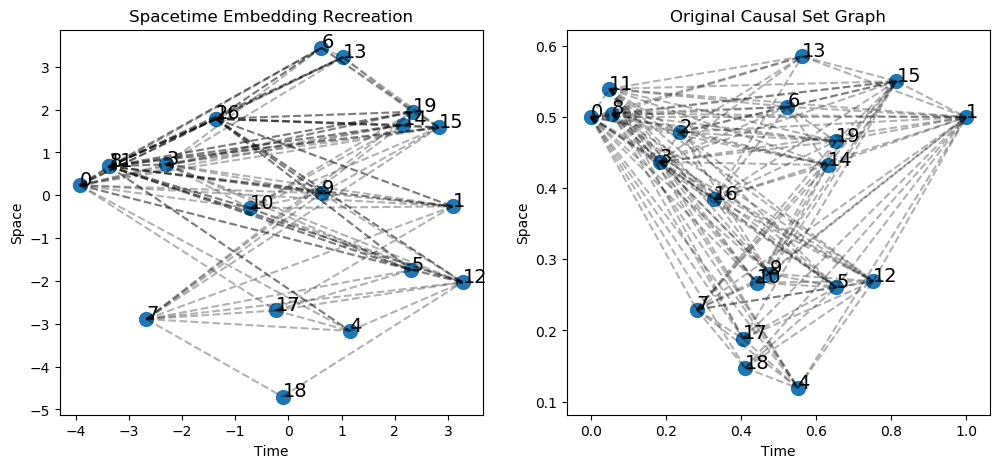

In [110]:
# evaluate on causal set graph
N = 20
G = causal_set_graph(N, 2)
embed = MinkowskiEmbedding(n_components=2) 
X = embed.fit(G)
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.title('Spacetime Embedding Recreation')
plt.xlabel('Time')
plt.ylabel('Space')
plt.scatter(X[:, 0], X[:, 1], s=100)
for i in range(N):
    _ = plt.text(X[i, 0], X[i, 1], str(i), size=14);
for u,v in add_edges(X):
    _ = plt.plot([X[u][0], X[v][0]], [X[u][1], X[v][1]], c='black', linestyle='--', alpha=0.3);
plt.subplot(122)
plt.title('Original Causal Set Graph')
plt.xlabel('Time')
plt.ylabel('Space')
X_orig = np.array([G.node[i]['position'] for i in range(N)])
plt.scatter(X_orig[:, 0], X_orig[:, 1], s=100)
for i in range(N):
    _ = plt.text(X_orig[i, 0], X_orig[i, 1], str(i), size=14);
for u,v in list(G.edges()):
    _ = plt.plot([X_orig[u][0], X_orig[v][0]], [X_orig[u][1], X_orig[v][1]], 
                 alpha=0.3, c='black', linestyle='--');
plt.show();

0.8203125

0.9852941176470589

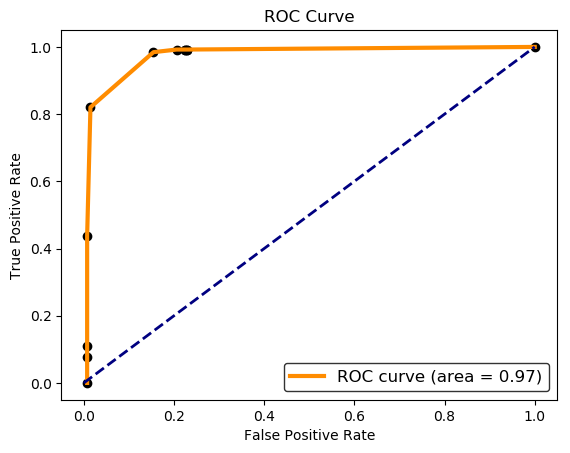

0.9724839154411764

In [111]:
sensitivity(G, embed.predict(G))
specificity(G, embed.predict(G))
plt.style.use('default')
plot_roc_curve(G, X)
roc_auc_score(G, X)

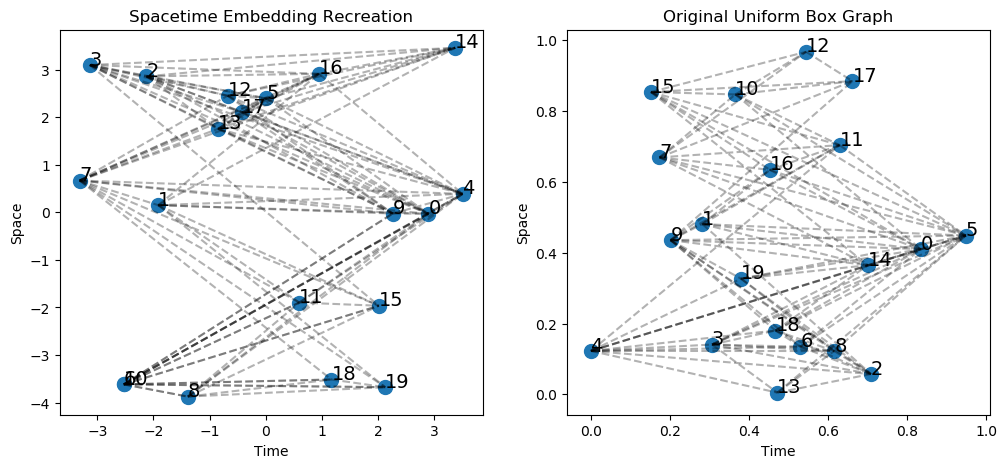

In [120]:
# evaluate on uniform box graph
N = 20
G = uniform_box_graph(N, 2)
embed = MinkowskiEmbedding(n_components=2) 
X = embed.fit(G)
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.title('Spacetime Embedding Recreation')
plt.xlabel('Time')
plt.ylabel('Space')
plt.scatter(X[:, 0], X[:, 1], s=100)
for i in range(N):
    _ = plt.text(X[i, 0], X[i, 1], str(i), size=14);
for u,v in add_edges(X):
    _ = plt.plot([X[u][0], X[v][0]], [X[u][1], X[v][1]], c='black', alpha=0.3, linestyle='--');
plt.subplot(122)
plt.title('Original Uniform Box Graph')
plt.xlabel('Time')
plt.ylabel('Space')
X_orig = np.array([G.node[i]['position'] for i in range(N)])
plt.scatter(X_orig[:, 0], X_orig[:, 1], s=100)
for i in range(N):
    _ = plt.text(X_orig[i, 0], X_orig[i, 1], str(i), size=14);
for u,v in list(G.edges()):
    _ = plt.plot([X_orig[u][0], X_orig[v][0]], [X_orig[u][1], X_orig[v][1]], 
                 c='black', alpha=0.3, linestyle='--');
plt.show();

0.9883720930232558

0.9617834394904459

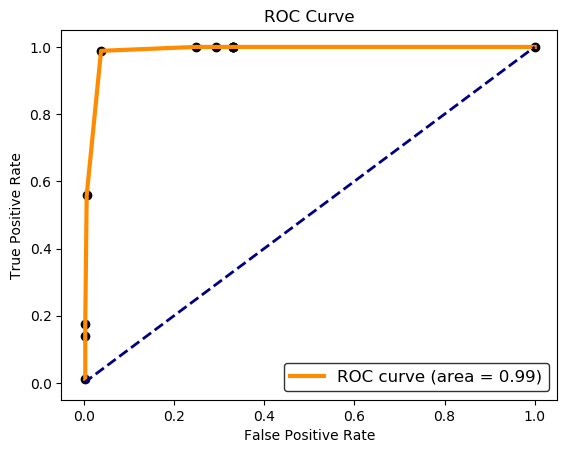

In [121]:
sensitivity(G, embed.predict(G))
specificity(G, embed.predict(G))
plt.style.use('default')
plot_roc_curve(G, X)

## Ex 2.) Citation Networks

**hep-th arxiv paper citations**

In [122]:
import pandas as pd
hep_df = pd.read_csv('hep-th-citations.tar.gz', compression='gzip', dtype=str)
hep_df = hep_df.dropna()
hep_df['cited_from'] = hep_df['hep-th-citations'].apply(lambda x: str(x).split(' ')[0])
hep_df['cited_to'] = hep_df['hep-th-citations'].apply(lambda x: str(x).split(' ')[1])
hep_df = hep_df.iloc[:, 1:]
hep_df.head()

,cited_from,cited_to
0,0001001,9308122
1,0001001,9309097
2,0001001,9311042
3,0001001,9401139
4,0001001,9404151


In [123]:
slac_dates = pd.read_csv('hep-th-slacdates.tar.gz', compression='gzip', dtype=str)
slac_dates = slac_dates.dropna()
slac_dates['arxiv_id'] = slac_dates['hep-th-slacdates'].apply(lambda x: str(x).split(' ')[0])
slac_dates['date'] = slac_dates['hep-th-slacdates'].apply(lambda x: str(x).split(' ')[1])
slac_dates = slac_dates.iloc[:, 1:]
slac_dates.head()
slac_dates.shape

,arxiv_id,date
0,0001002,2000-01-04
1,0001003,2000-01-04
2,0001004,2000-01-04
3,0001005,2000-01-04
4,0001006,2000-01-04


(29554, 2)

In [136]:
import datetime
N = 40
top_cited = list(hep_df.cited_to.value_counts()[:N].index)
edges = []
for node in top_cited:
    cited_by = hep_df.loc[hep_df.cited_to == node, 'cited_from'].values
    for x in cited_by:
        if x in top_cited:
            edges.append((x, node))

degree_dict = dict(zip(hep_df.cited_to.value_counts()[:N].index,
                       hep_df.cited_to.value_counts()[:N].values))
top_cited_df = slac_dates.loc[(slac_dates.arxiv_id.apply(lambda x: x in top_cited)), :]
top_cited_df = top_cited_df.reset_index(drop=True)
top_cited_df['degree'] = top_cited_df.arxiv_id.apply(lambda x: degree_dict[x])
top_cited_df['num_date'] = top_cited_df.date
top_cited_df['date_time'] = top_cited_df.date.apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))
top_cited_df['num_date'] = top_cited_df.date_time - np.min(top_cited_df.date_time)
top_cited_df['num_date'] = top_cited_df['num_date'].dt.days
top_cited_df['num_date'] = top_cited_df.num_date / np.max(top_cited_df.num_date)
date_dict = dict(zip(top_cited_df.arxiv_id.values, top_cited_df.num_date))

In [137]:
G = nx.DiGraph()
for node in top_cited:
    G.add_node(node)
G.add_edges_from(edges)
embed = MinkowskiEmbedding(n_components=2)
X = embed.fit(G)

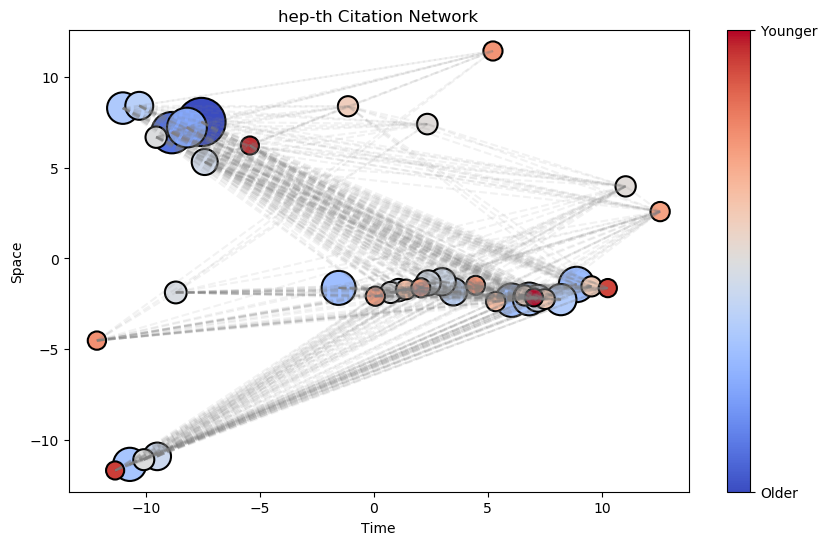

In [141]:
plt.style.use('default')
plt.figure(figsize=(10,6))
plt.grid('off')
#plt.axis('off')
plt.title('hep-th Citation Network')
plt.ylabel('Space')
plt.xlabel('Time')
node_list = list(G.nodes())
node_colors = np.array(list(date_dict.values()))
node_sizes = np.array(list(degree_dict.values()))
im = plt.scatter(X[:, 0], X[:, 1], s = node_sizes/2, c = node_colors, cmap=plt.cm.coolwarm,
                vmin=0, vmax=1, edgecolor='black', linewidth=1.5)
for u,v in add_edges(X):
    _ = plt.plot([X[u][0], X[v][0]], [X[u][1], X[v][1]], c='gray', linestyle='--', alpha=0.1);
cbar = plt.colorbar(im);
cbar.set_ticks([0, 1]);
cbar.set_ticklabels(['Older', 'Younger'])
#plt.savefig('hep-th_citation_network.png')
plt.show();

0.9221556886227545

0.6908583391486393

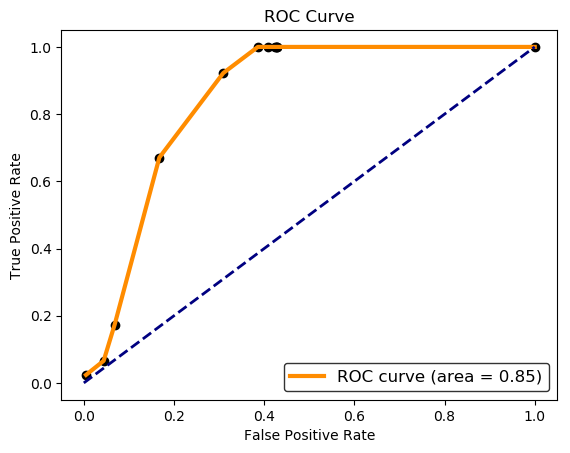

In [142]:
sensitivity(G, embed.predict(G))
specificity(G, embed.predict(G))
plot_roc_curve(G, X)

## SCOTUS Citation Network